<a href="https://colab.research.google.com/github/NehaKumari500092077/Deep-Learning-Lab/blob/main/Programming%20Assignment%205%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ucimlrepo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [ ]:
import random
import numpy as np
import torch

random.seed(43)
np.random.seed(43)
torch.manual_seed(43)
torch.cuda.manual_seed(43)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


1.Loading the Landsat dataset from UCI.  

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_landsat_satellite = fetch_ucirepo(id=146)

# data (as pandas dataframes)
X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets

# metadata
print(statlog_landsat_satellite.metadata)

# variable information
print(statlog_landsat_satellite.variables)


{'uci_id': 146, 'name': 'Statlog (Landsat Satellite)', 'repository_url': 'https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite', 'data_url': 'https://archive.ics.uci.edu/static/public/146/data.csv', 'abstract': 'Multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood', 'area': 'Climate and Environment', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6435, 'num_features': 36, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C55887', 'creators': ['Ashwin Srinivasan'], 'intro_paper': None, 'additional_info': {'summary': "The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification as

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Checking the dataset for missing and duplicate entries. Show the class distribution of the dataset and report whether the dataset is balanced/imbalanced.

In [ ]:
# Check for missing values
missing_values = X.isnull().sum().sum()

# Check for duplicate entries
duplicate_entries = X.duplicated().sum()

missing_values, duplicate_entries


(0, 0)

In [ ]:
# Class distribution
# Convert NumPy array to Pandas Series
Y = pd.Series(y)

# Class distribution
class_counts = Y.value_counts().sort_index()
print(class_counts)


0    1533
1     703
2    1358
3     626
4     707
5    1508
Name: count, dtype: int64


**So its a imbalaned dataset so F1 score is more important to understand if the model is performing well or not . **

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)


In [ ]:
X.shape

(6435, 36)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# Implementing Batch Normalization from Scratch
class BatchNormLayer(nn.Module):
    def __init__(self, num_features, epsilon=1e-5, momentum=0.1):
        super(BatchNormLayer, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            x_norm = (x - mean) / torch.sqrt(var + self.epsilon)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            x_norm = (x - self.running_mean) / torch.sqrt(self.running_var + self.epsilon)
        return self.gamma * x_norm + self.beta

3.Designing a neural network with few hidden layers to perform multi-class classification on this dataset.

In [ ]:
# Define Neural Network with Increased Depth
class LandsatNN(nn.Module):
    def __init__(self, input_size=36, hidden_sizes=[128, 64, 32, 16], output_size=6, use_custom_bn=False):
        super(LandsatNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

        if use_custom_bn:
            self.bn1 = BatchNormLayer(hidden_sizes[0], epsilon=1e-5, momentum=0.1)
            self.bn2 = BatchNormLayer(hidden_sizes[1], epsilon=1e-5, momentum=0.1)
            self.bn3 = BatchNormLayer(hidden_sizes[2], epsilon=1e-5, momentum=0.1)
            self.bn4 = BatchNormLayer(hidden_sizes[3], epsilon=1e-5, momentum=0.1)
        else:
            self.bn1 = nn.BatchNorm1d(hidden_sizes[0], eps=1e-5, momentum=0.1)
            self.bn2 = nn.BatchNorm1d(hidden_sizes[1], eps=1e-5, momentum=0.1)
            self.bn3 = nn.BatchNorm1d(hidden_sizes[2], eps=1e-5, momentum=0.1)
            self.bn4 = nn.BatchNorm1d(hidden_sizes[3], eps=1e-5, momentum=0.1)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.use_custom_bn = use_custom_bn

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.fc5(x)
        return self.softmax(x)

4.Implement batch normalization and L1 regularization from scratch to train the above neural network.   

In [ ]:
# Define L1 Regularization from Scratch
def l1_regularization(model, lambda_l1):
    l1_loss = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_loss = l1_loss + torch.sum(torch.abs(param))
    return lambda_l1 * l1_loss

5.Train the neural network using Adam optimizer (from PyTorch).  

6.Use PyTorch’s batchnorm layer instead of the from scratch implementation of batch normalization and retrain the network with the same optimizer and same regularization.

In [ ]:
# Modify training function to store cross-entropy loss separately
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.001, l1_lambda=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []  # To store total loss
    train_ce_losses, test_ce_losses = [], []  # To store cross-entropy loss only

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        ce_loss = criterion(outputs, y_train)

        # L1 Regularization
        l1_loss = l1_regularization(model, l1_lambda)
        total_loss = ce_loss + l1_loss

        total_loss.backward()
        optimizer.step()

        train_losses.append(total_loss.item())
        train_ce_losses.append(ce_loss.item())  # Store only cross-entropy loss

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_ce_loss = criterion(test_outputs, y_test)
            test_ce_losses.append(test_ce_loss.item())

    return train_ce_losses, test_ce_losses  # Return only cross-entropy loss

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).argmax(dim=1).cpu().numpy()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    return acc, f1, cm

In [ ]:
# Train models with custom batch normalization and PyTorch's batch normalization
model_custom_bn = LandsatNN(use_custom_bn=True)
train_losses_custom_bn, test_losses_custom_bn = train_model(model_custom_bn, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=300,lr=0.0003,l1_lambda=0.001)
acc_custom_bn, f1_custom_bn, cm_custom_bn = evaluate_model(model_custom_bn, X_test_tensor, y_test_tensor)

model_pytorch_bn = LandsatNN(use_custom_bn=False)
train_losses_pytorch_bn, test_losses_pytorch_bn = train_model(model_pytorch_bn, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=300,lr=0.0003,l1_lambda=0.001)
acc_pytorch_bn, f1_pytorch_bn, cm_pytorch_bn = evaluate_model(model_pytorch_bn, X_test_tensor, y_test_tensor)


 Plot the training and validation losses against the number of epochs, and report the accuracy, F1 score and confusion matrix.

In [ ]:
# Print metrics
print(f"Custom BN - Accuracy: {acc_custom_bn:.4f}, F1 Score: {f1_custom_bn:.4f}")
print(f"PyTorch BN - Accuracy: {acc_pytorch_bn:.4f}, F1 Score: {f1_pytorch_bn:.4f}")


Custom BN - Accuracy: 0.8617, F1 Score: 0.8199
PyTorch BN - Accuracy: 0.8469, F1 Score: 0.8054


Show the corresponding loss plots, and compare the performance obtained with PyTorch’s batch normalization with the from scratch implementation.  

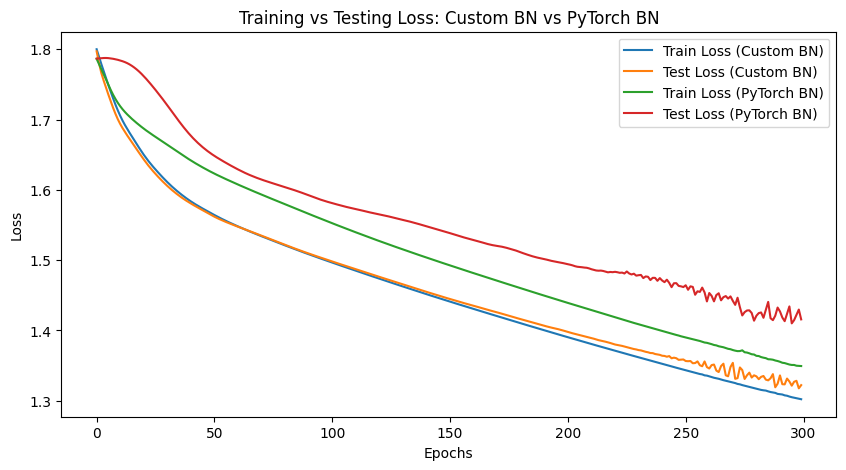

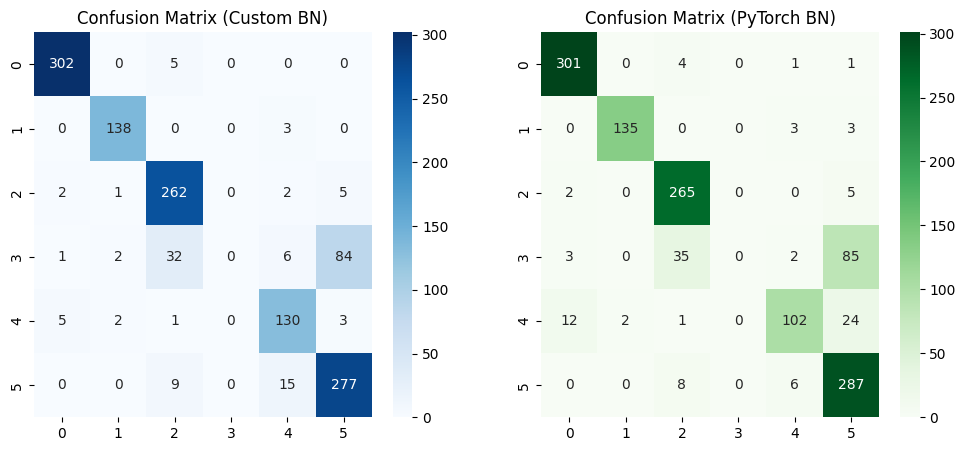

In [ ]:
# Plot Training vs Testing Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses_custom_bn, label="Train Loss (Custom BN)")
plt.plot(test_losses_custom_bn, label="Test Loss (Custom BN)")
plt.plot(train_losses_pytorch_bn, label="Train Loss (PyTorch BN)")
plt.plot(test_losses_pytorch_bn, label="Test Loss (PyTorch BN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Testing Loss: Custom BN vs PyTorch BN")
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_custom_bn, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix (Custom BN)")

sns.heatmap(cm_pytorch_bn, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix (PyTorch BN)")

plt.show()